<a href="https://colab.research.google.com/github/mel-oe/mel-oe/blob/main/oxides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mp_api
!pip install matminer

In [ ]:
pip install --upgrade numpy

In [ ]:
from mp_api.client import MPRester
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty, ElementFraction, Meredig, Stoichiometry
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error as mse

#from materials_project_api_key import api_key as api_key

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

AttributeError: module 'numpy.linalg._umath_linalg' has no attribute '_ilp64'

# Get Dataset

In [ ]:
properties = ["material_id",'formula','spacegroup.symbol','structure',"band_gap"]
elements = ["Ga,O", "In,O"]
data = []
for e in elements:
    with MPRester('UxYiT0ht7YNg2b6k0oqUVi7LtrUCf9m6') as m:
        temp = m.materials.summary.search(elements=[e])
        data.append(temp)
data

In [ ]:
formatted_data = [item for sublist in data for item in sublist]
new_data = []
for doc in formatted_data:
    new_data.append({
        'material_id': doc.material_id,
        'energy_per_atom': doc.energy_per_atom,
        'structure': doc.structure,
        'composition_dict':doc.composition.as_dict(),
        'formula':doc.formula_pretty,
        'n_elements':doc.nelements,
        'elements':doc.elements,
        'band_gap':doc.band_gap,
        'chemsys':doc.chemsys,
        'comp':doc.composition
    })

dfC = pd.DataFrame(new_data)
dfC

,material_id,energy_per_atom,structure,composition_dict,formula,n_elements,elements,band_gap,chemsys,comp
0,mp-1262161,-6.702879,"[[2.83845726 7.1894766 7.22828084] Na, [0.775...","{'Na': 4.0, 'Ca': 4.0, 'Ga': 4.0, 'Si': 8.0, '...",NaCaGaSi2O7,5,"[Ca, Ga, Na, O, Si]",2.8233,Ca-Ga-Na-O-Si,"(Na, Ca, Ga, Si, O)"
1,mp-1099261,-5.503227,"[[0. 0. 0.] Cs, [0. 0. 4.6645005...","{'Cs': 1.0, 'Mg': 6.0, 'Ga': 1.0, 'O': 8.0}",CsMg6GaO8,4,"[Cs, Ga, Mg, O]",0.0000,Cs-Ga-Mg-O,"(Cs, Mg, Ga, O)"
2,mp-22540,-14.123006,"[[2.2067335 2.2067335 2.2067335] Ce, [0. 0. 0....","{'Ce': 1.0, 'Ga': 1.0, 'O': 3.0}",CeGaO3,3,"[Ce, Ga, O]",0.0000,Ce-Ga-O,"(Ce, Ga, O)"
3,mp-2714778,-7.606091,"[[1.5969632 2.80239442 5.63836276] Na, [ 2.89...","{'Na': 9.0, 'Zr': 9.0, 'Ga': 3.0, 'Si': 9.0, '...",Na3Zr3GaSi3(SO8)3,6,"[Ga, Na, O, S, Si, Zr]",3.6423,Ga-Na-O-S-Si-Zr,"(Na, Zr, Ga, Si, S, O)"
4,mp-768505,-7.698666,"[[2.95133158 1.70392387 2.68473439] Lu, [6.366...","{'Lu': 6.0, 'Ga': 6.0, 'O': 18.0}",LuGaO3,3,"[Ga, Lu, O]",2.8828,Ga-Lu-O,"(Lu, Ga, O)"
...,...,...,...,...,...,...,...,...,...,...
2574,mp-1204264,-5.805155,"[[ 1.78854229 3.84732855 14.74507834] In, [5....","{'In': 24.0, 'Ga': 8.0, 'Ir': 4.0, 'O': 30.0}",In12Ga4Ir2O15,4,"[Ga, In, Ir, O]",1.4187,Ga-In-Ir-O,"(In, Ga, Ir, O)"
2575,mp-40373,-5.204468,[[ 6.74444589e+00 -5.92170527e-17 9.07742650e...,"{'In': 14.0, 'Ga': 3.0, 'Pt': 2.0, 'O': 8.0, '...",In14Ga3Pt2O8F15,5,"[F, Ga, In, O, Pt]",1.9925,F-Ga-In-O-Pt,"(In, Ga, Pt, O, F)"
2576,mp-867998,-14.511487,"[[ 7.64344992 -1.55355609 1.5679655 ] In, [ 2...","{'In': 15.0, 'Sn': 1.0, 'O': 24.0}",In15SnO24,3,"[In, O, Sn]",0.0000,In-O-Sn,"(In, Sn, O)"
2577,mp-766006,-14.509669,"[[2.55356964 5.40414256 1.80182933] In, [-2.53...","{'In': 15.0, 'Sn': 1.0, 'O': 24.0}",In15SnO24,3,"[In, O, Sn]",0.0000,In-O-Sn,"(In, Sn, O)"


# Dataset post-processing



In [ ]:
# Get atom counts
atom_counts = {}
for row in tqdm(dfC.composition_dict):
    for key in row.keys():
        atom_counts[key] = atom_counts[key] + row[key] if key in atom_counts.keys() else row[key]
crystal_atom_counts = pd.Series({ key:atom_counts[key] for key in sorted(atom_counts.keys()) })

100%|██████████| 2579/2579 [00:00<00:00, 98930.95it/s]


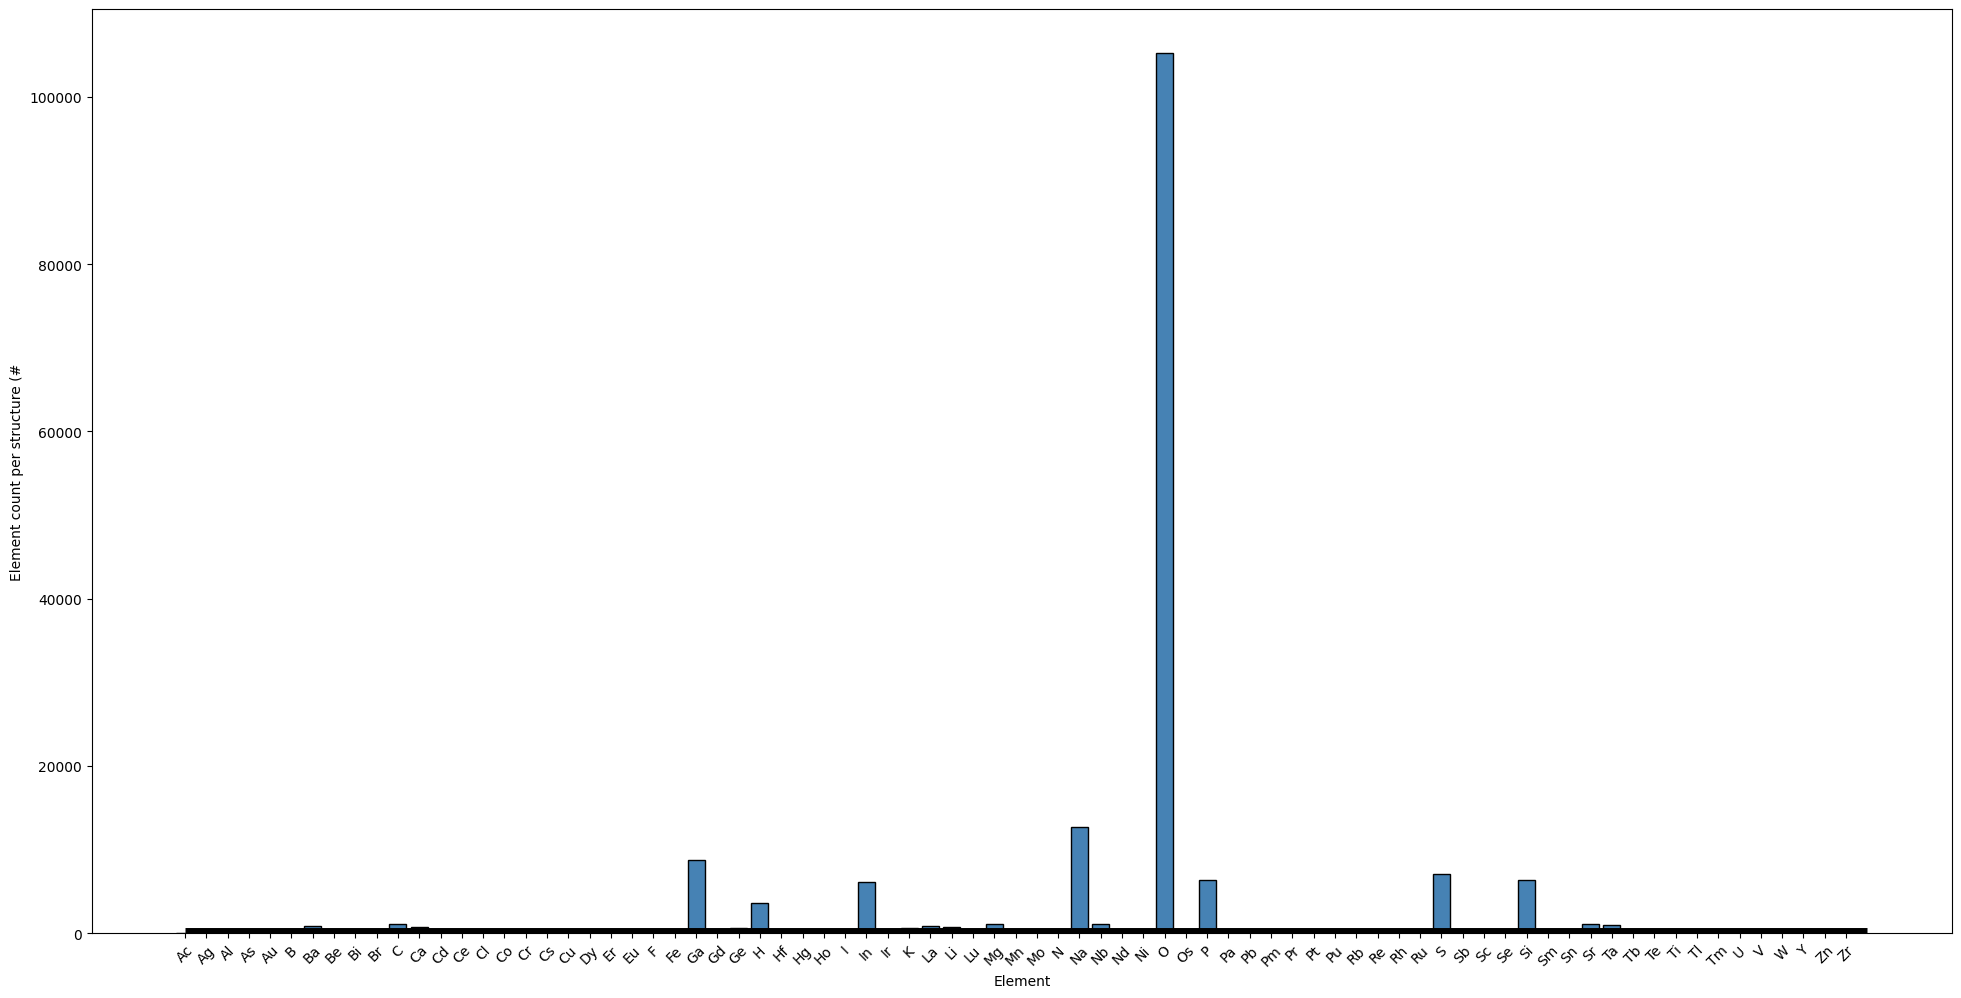

In [ ]:
# Plot atom counts, only considering if atom of that type is in the crystal
fig, ax = plt.subplots(figsize=[24,12], dpi=100)
ax.bar(crystal_atom_counts.index, crystal_atom_counts.values, edgecolor='k', color='steelblue')
plt.xticks(rotation=45)
ax.set_xlabel('Element')
ax.set_ylabel('Element count per structure (#')
ax.hlines(y=300, xmin=0, xmax=len(crystal_atom_counts.index), color='k', linewidth=5)

In [ ]:
# Only choose structures with elements that are well represented in the dataset
n_crystals_cutoff = 300
elements = [key for key in crystal_atom_counts.keys() if crystal_atom_counts[key] >= n_crystals_cutoff]
print(f"Allowed Elements: {elements}")
print(f"Number of Elements: {len(elements)}")

# Lets now filter the structures
mask = [row[1].name for row in dfC.iterrows() if np.all(np.isin(list(row[1].composition_dict.keys()), elements))]

Allowed Elements: ['Al', 'B', 'Ba', 'C', 'Ca', 'Cu', 'F', 'Ga', 'Ge', 'H', 'Hf', 'In', 'K', 'La', 'Li', 'Mg', 'Mo', 'N', 'Na', 'Nb', 'O', 'P', 'Rb', 'S', 'Sc', 'Se', 'Si', 'Sn', 'Sr', 'Ta', 'Ti', 'Y', 'Zn', 'Zr']
Number of Elements: 34


In [ ]:
filtered = dfC.loc[mask]
filtered = filtered.loc[filtered.band_gap > 0]
filtered

,material_id,energy_per_atom,structure,composition_dict,formula,n_elements,elements,band_gap,chemsys,comp
0,mp-1262161,-6.702879,"[[2.83845726 7.1894766 7.22828084] Na, [0.775...","{'Na': 4.0, 'Ca': 4.0, 'Ga': 4.0, 'Si': 8.0, '...",NaCaGaSi2O7,5,"[Ca, Ga, Na, O, Si]",2.8233,Ca-Ga-Na-O-Si,"(Na, Ca, Ga, Si, O)"
3,mp-2714778,-7.606091,"[[1.5969632 2.80239442 5.63836276] Na, [ 2.89...","{'Na': 9.0, 'Zr': 9.0, 'Ga': 3.0, 'Si': 9.0, '...",Na3Zr3GaSi3(SO8)3,6,"[Ga, Na, O, S, Si, Zr]",3.6423,Ga-Na-O-S-Si-Zr,"(Na, Zr, Ga, Si, S, O)"
6,mp-2716516,-7.787042,"[[6.10656991 4.88091889 5.4798128 ] Na, [ 2.92...","{'Na': 15.0, 'Nb': 9.0, 'Ga': 3.0, 'Si': 15.0,...",Na5Nb3GaSi5PO24,6,"[Ga, Na, Nb, O, P, Si]",2.5221,Ga-Na-Nb-O-P-Si,"(Na, Nb, Ga, Si, P, O)"
8,mp-540945,-5.197113,"[[0. 2.08444436 6.29641504] Na, [0. ...","{'Na': 8.0, 'Li': 12.0, 'Ga': 4.0, 'O': 16.0}",Na2Li3GaO4,4,"[Ga, Li, Na, O]",3.2395,Ga-Li-Na-O,"(Na, Li, Ga, O)"
9,mp-1034314,-6.212093,"[[0. 0. 0.] Na, [0. 4.27142967 0. ...","{'Na': 1.0, 'Mg': 14.0, 'Ga': 1.0, 'O': 16.0}",NaMg14GaO16,4,"[Ga, Mg, Na, O]",3.1921,Ga-Mg-Na-O,"(Na, Mg, Ga, O)"
...,...,...,...,...,...,...,...,...,...,...
2567,mp-2715669,-6.434868,"[[10.44427126 7.92302735 5.44890518] Na, [1....","{'Na': 42.0, 'In': 24.0, 'Si': 21.0, 'S': 15.0...",Na14In8Si7S5O48,5,"[In, Na, O, S, Si]",2.5298,In-Na-O-S-Si,"(Na, In, Si, S, O)"
2568,mp-2714947,-6.445177,"[[6.03006408 0.03325436 5.79326473] Na, [10.56...","{'Na': 30.0, 'In': 24.0, 'Si': 15.0, 'S': 21.0...",Na10In8Si5S7O48,5,"[In, Na, O, S, Si]",2.4369,In-Na-O-S-Si,"(Na, In, Si, S, O)"
2569,mp-2714314,-6.453714,"[[-4.38163857 7.62878849 11.69522089] Na, [ 8...","{'Na': 6.0, 'In': 24.0, 'Si': 3.0, 'S': 33.0, ...",Na2In8SiS11O48,5,"[In, Na, O, S, Si]",1.2404,In-Na-O-S-Si,"(Na, In, Si, S, O)"
2570,mp-2713837,-6.452632,"[[-2.77687493 5.04672116 5.97126399] Na, [ 7...","{'Na': 18.0, 'In': 24.0, 'Si': 9.0, 'S': 27.0,...",Na6In8Si3(S3O16)3,5,"[In, Na, O, S, Si]",1.6844,In-Na-O-S-Si,"(Na, In, Si, S, O)"


Text(0, 0.5, 'Count')

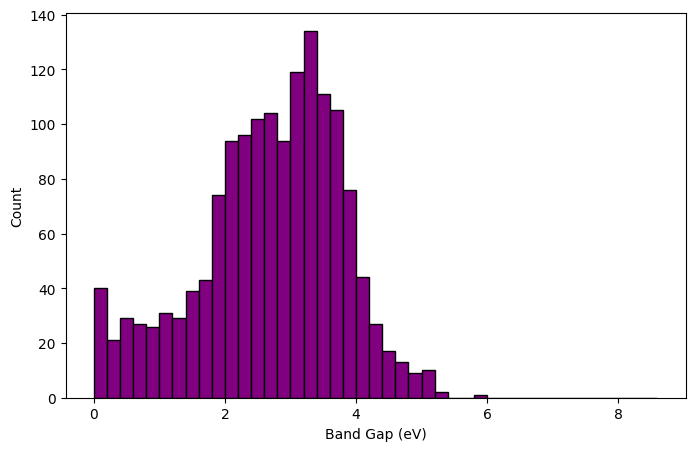

In [ ]:
# Lets take a look at the distribution of band gaps
fig, ax = plt.subplots(figsize=[8, 5], dpi=100)
ax.hist(filtered.band_gap, color='purple', edgecolor='k', bins=np.linspace(0, 8.6, 44))
ax.set_xlabel('Band Gap (eV)')
ax.set_ylabel('Count')

# Featurise Dataset

In [ ]:
semiconductors = StrToComposition().featurize_dataframe(filtered, "comp")

# Define the featuriser


# Define Model

In [ ]:
# Define a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=128)

# Train/Validate Model

# Results